In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import os
import random
import re
from nltk.sentiment import SentimentIntensityAnalyzer
import datetime
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\amoueye\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import utils
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
df= pd.read_csv('../Data/sentiment_labels.csv')

In [4]:
df.head()

,date,adj_close,volume,ticker,1_day_return,predicted_label
0,2017-01-31,28.308922,196804000,AAPL,-0.002307,0
1,2017-01-31,28.308922,196804000,AAPL,-0.002307,1
2,2017-01-31,28.308922,196804000,AAPL,-0.002307,1
3,2017-01-31,28.308922,196804000,AAPL,-0.002307,2
4,2017-01-31,28.308922,196804000,AAPL,-0.002307,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124244 entries, 0 to 124243
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date             124244 non-null  object 
 1   adj_close        124244 non-null  float64
 2   volume           124244 non-null  int64  
 3   ticker           124244 non-null  object 
 4   1_day_return     124244 non-null  float64
 5   predicted_label  124244 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 5.7+ MB


In [6]:
df['date'] =  pd.to_datetime(df['date'])

In [7]:
tickers= list(df['ticker'].unique())

In [8]:
tickers

['AAPL',
 'ADDYY',
 'AMZN',
 'BMWYY',
 'BP',
 'DIS',
 'EBAY',
 'F',
 'GOOGL',
 'HNDAF',
 'HP',
 'IBM',
 'INTC',
 'META',
 'MSFT',
 'NEXT',
 'NFLX',
 'NKE',
 'PARA',
 'PYPL',
 'RYAAY',
 'SBUX',
 'SONY',
 'TM',
 'TRI',
 'UPS',
 'V',
 'WMT']

In [9]:
def get_stock_info (tic):
    df_tic= df[df.ticker== tic]. groupby('date')[['adj_close','predicted_label']].mean()
    return  df_tic

In [10]:
get_stock_info('AAPL')

,adj_close,predicted_label
date,,
2017-01-31,28.308922,1.189189
2017-02-01,30.035215,1.175824
2017-02-28,32.096031,1.204969
2017-03-01,32.752052,1.232143
2017-03-31,33.658768,1.198953
...,...,...
2018-10-19,52.581047,1.375887
2018-10-23,53.401020,1.287500
2018-10-24,51.569279,1.375000


In [11]:
def stock_plot(tic):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    get_stock_info(tic)['predicted_label'].plot(ax= ax1, c= 'g')
    get_stock_info(tic)['adj_close'].plot(ax= ax2, c= 'b')

    ax1.set_xlabel('date')
    ax1.set_ylabel('sentiment labels', color='g')
    ax2.set_ylabel('stock price', color='b')
    plt.xticks(rotation=90)
    plt.title('Stock Return and Sentiment Labels for {}'.format(tic))
    plt.show();

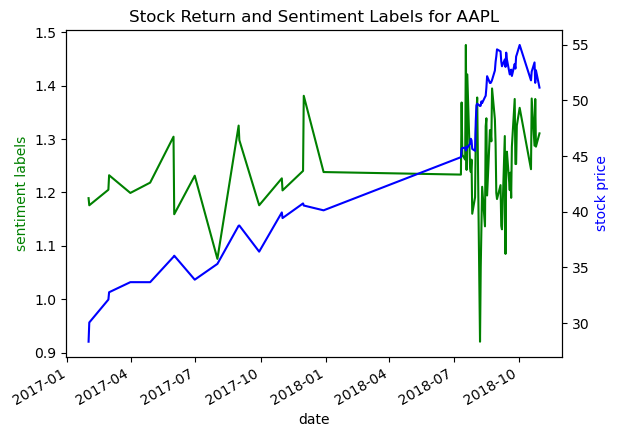

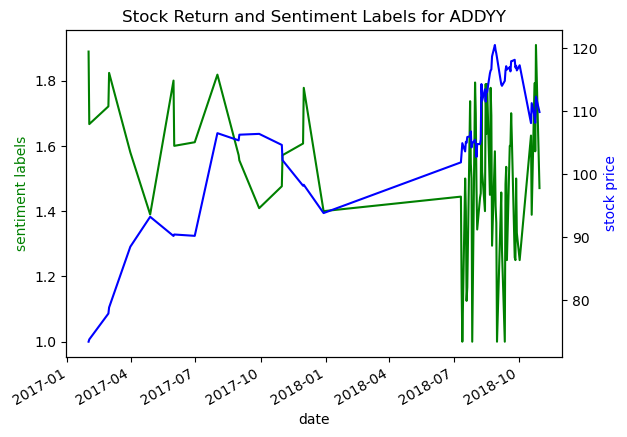

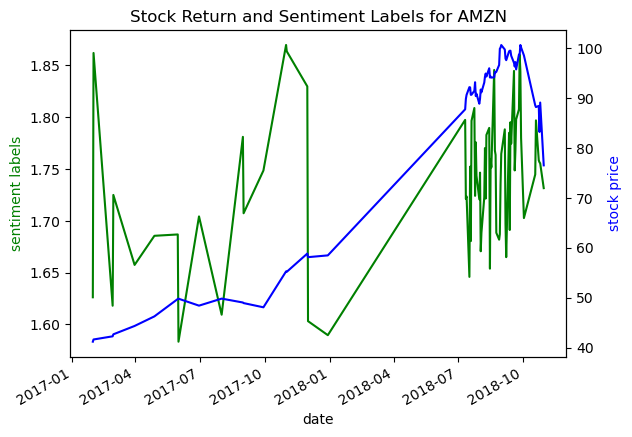

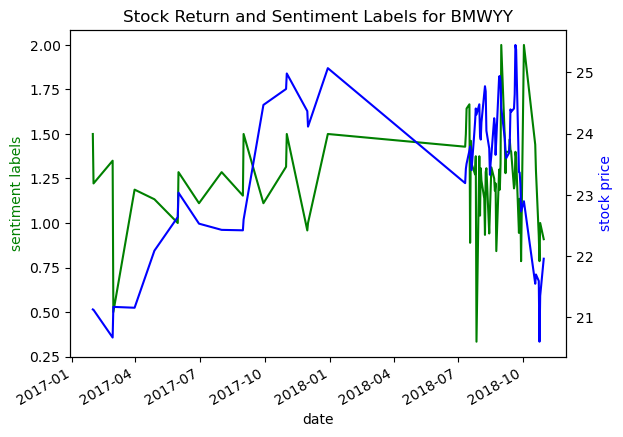

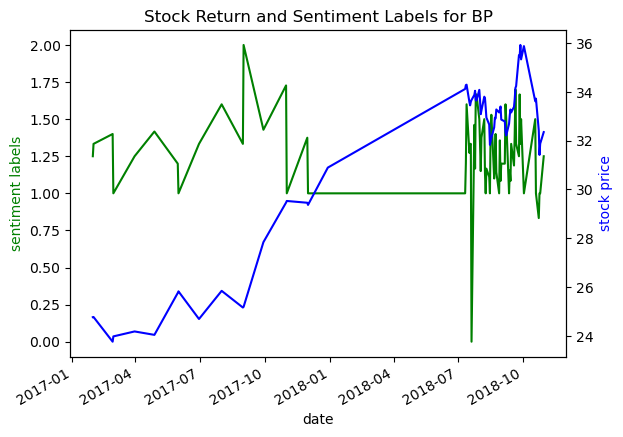

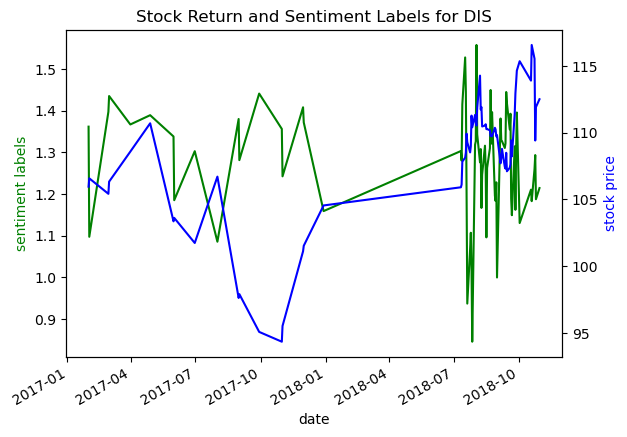

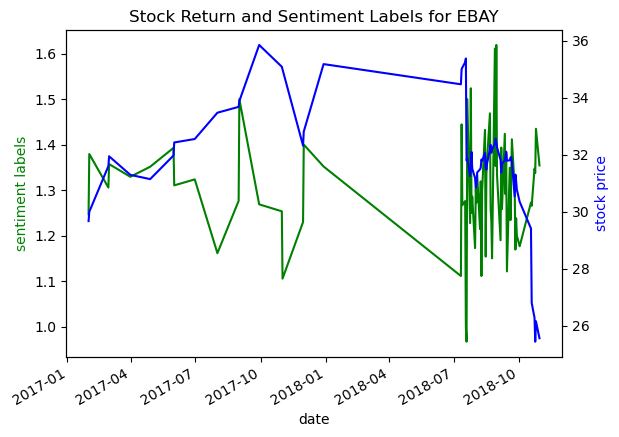

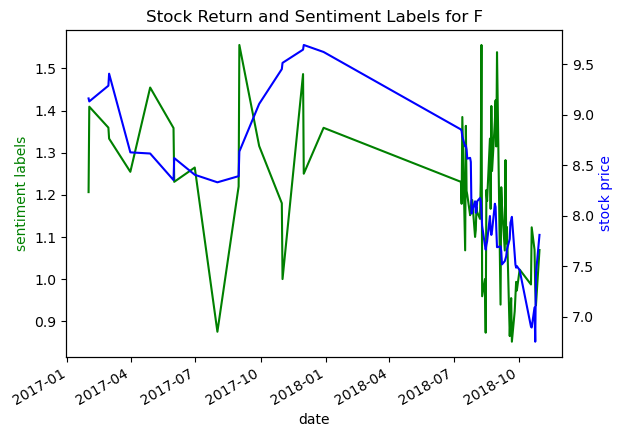

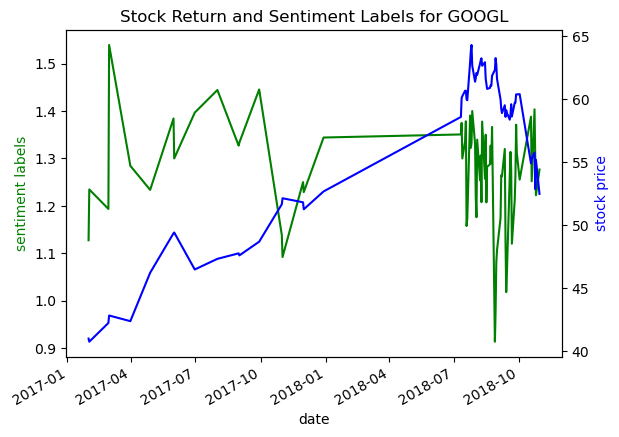

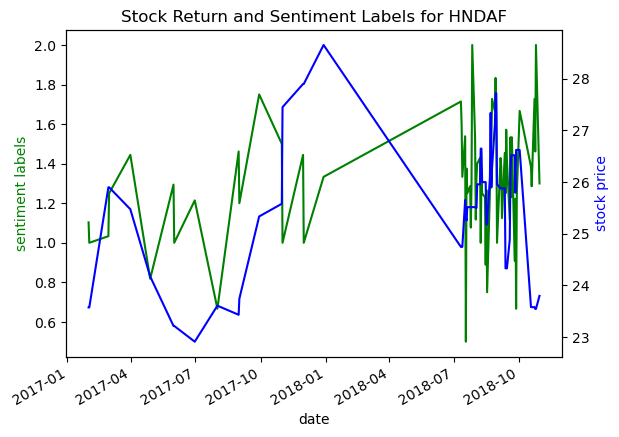

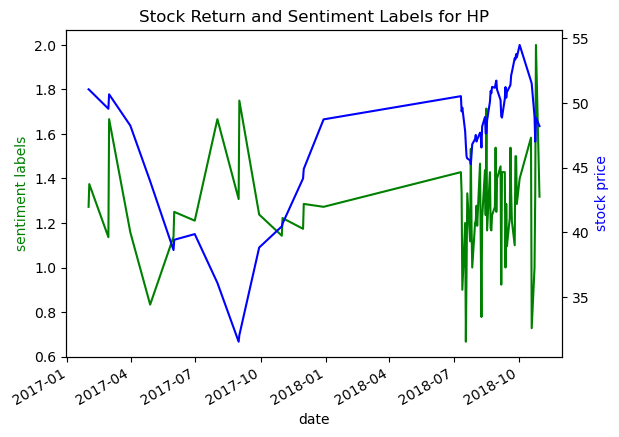

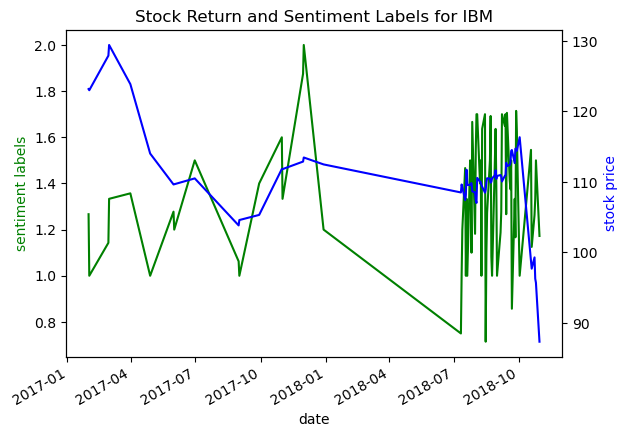

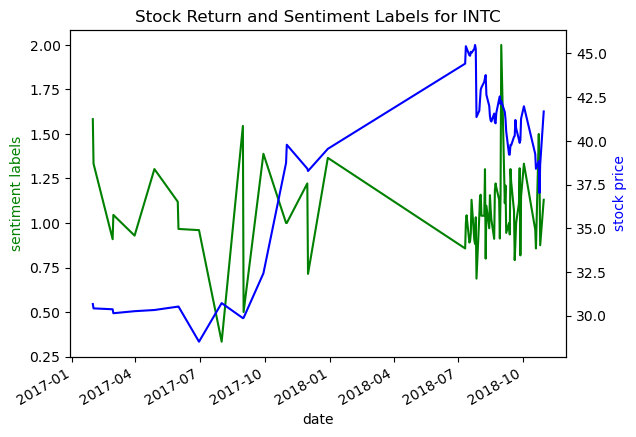

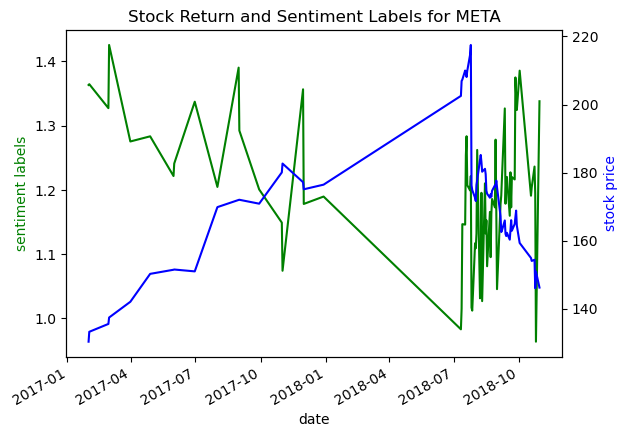

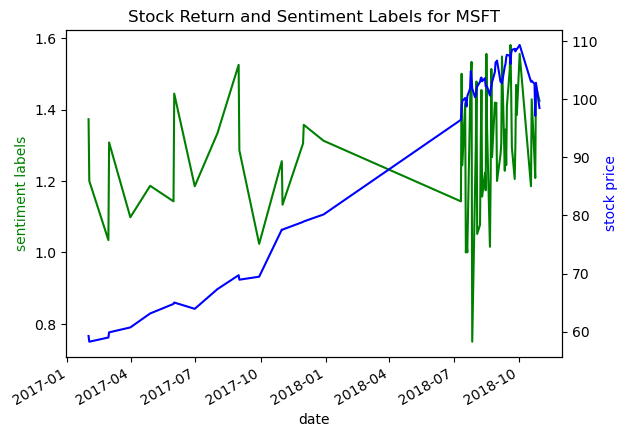

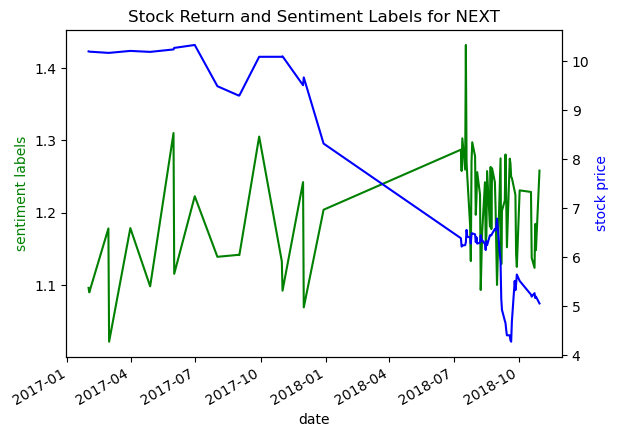

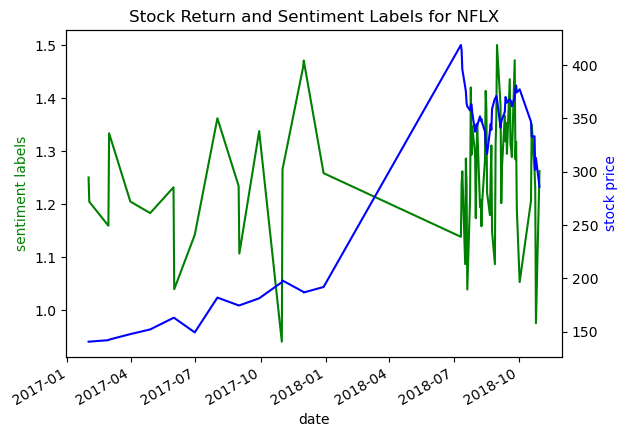

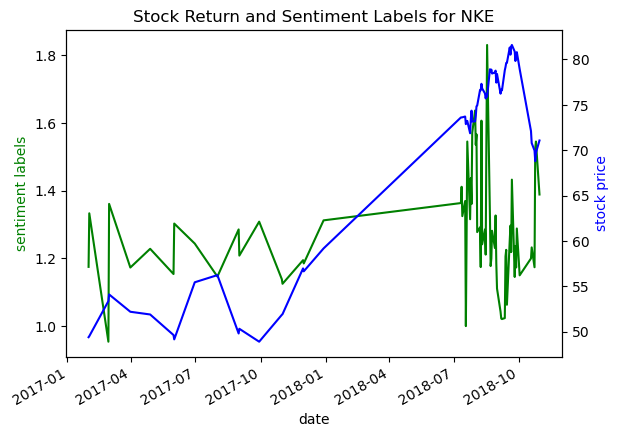

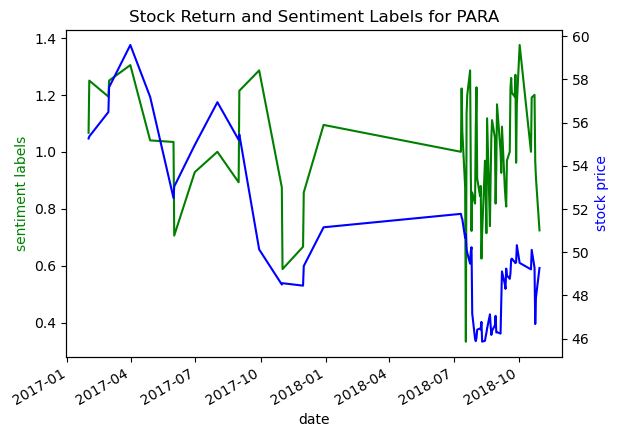

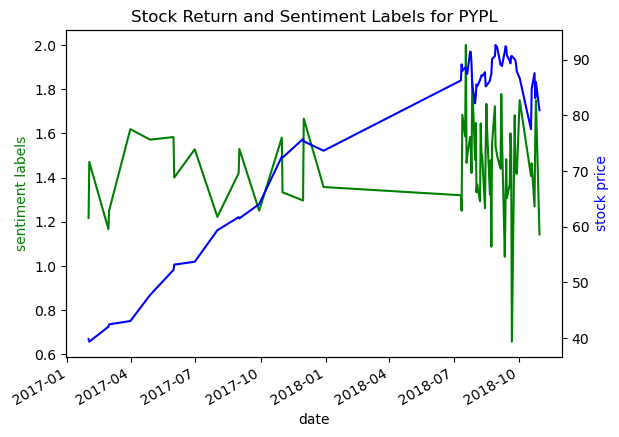

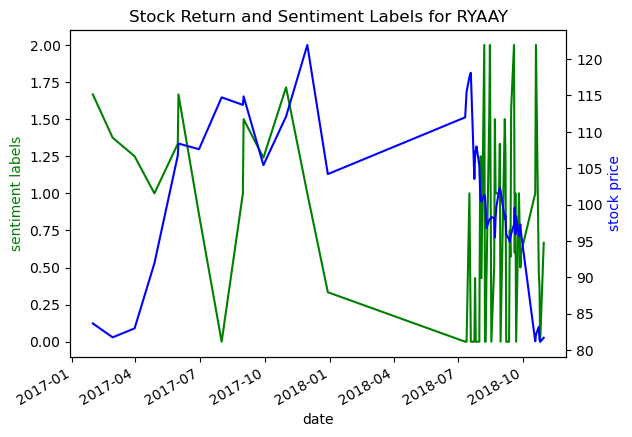

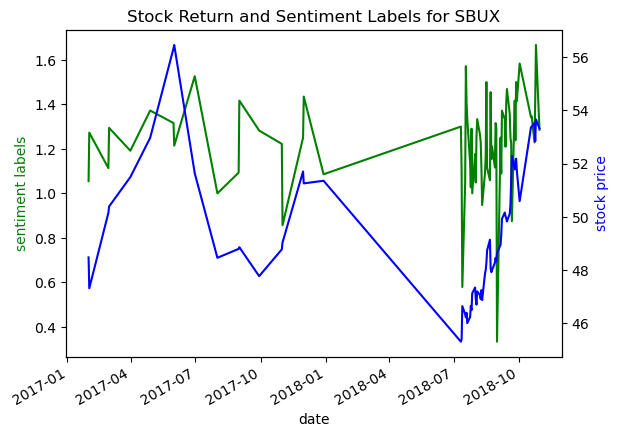

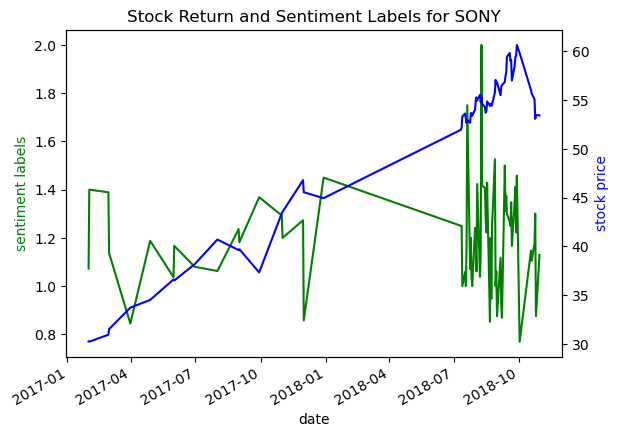

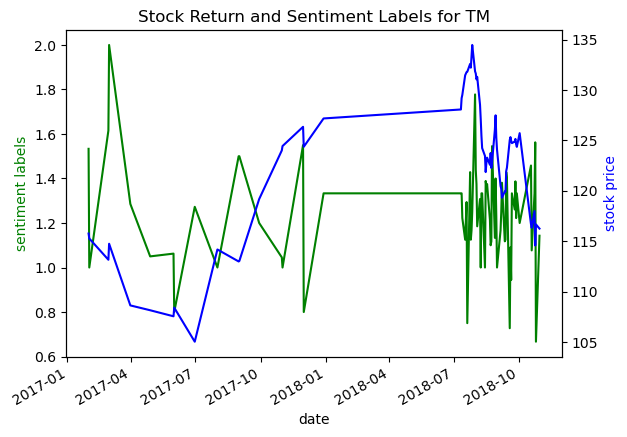

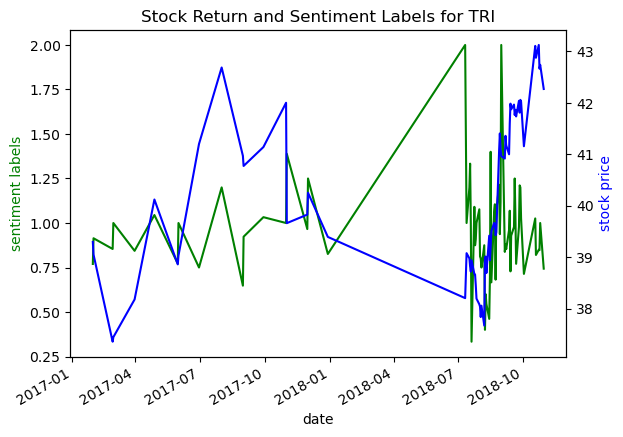

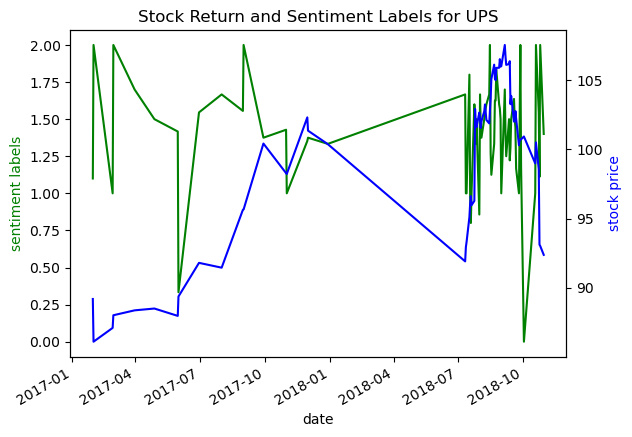

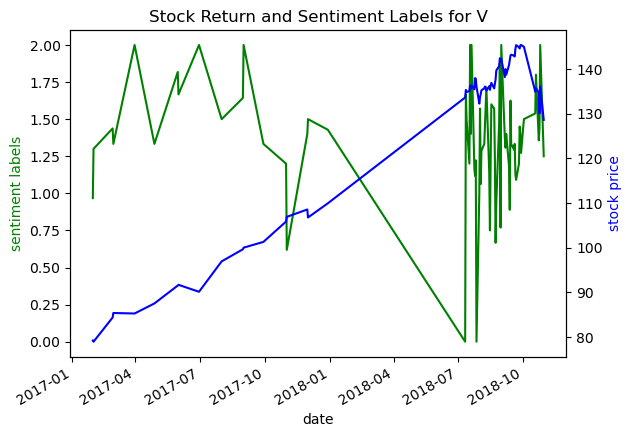

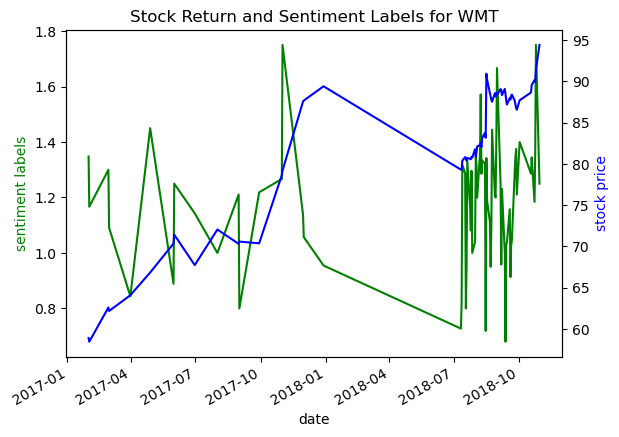

In [12]:
for tic in tickers: 
    stock_plot(tic)

# 5. Prepare dataset for LSTM model

In [13]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [14]:
# create a function to convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df1 = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df1.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df1.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        return agg

-----------------------------------------

## 6- Define and fit the model for one stock

In [15]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [16]:
df1= get_stock_info('AMZN')

In [17]:
#Convert dataframe to arrays and ensure all data is float

values= df1.values
values= values.astype('float32')

In [18]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

In [19]:
# frame as supervised learning
n_days= 10
n_features= 2
reframed = series_to_supervised(scaled, n_days, 1)

>We have (10 * 2) + 2 columns in our framed dataset now. We will take 10*2 or 20 columns as input for the observations of all features across the previous 10 days. We will take just the "treated_water_ph" variable as output at the following hour.

In [20]:
# print(reframed.head())

In [21]:
# split into train and test sets
values = reframed.values
n_test_hours = int(0.25 * reframed.shape[0])
train = values[n_test_hours:, :]
test = values[:n_test_hours, :]


In [22]:

# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(46, 20) 46 (46,)


In [23]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(46, 10, 2) (46,) (15, 10, 2) (15,)


In [24]:
# design network
model = Sequential()
model.add(LSTM(400, input_shape=(train_X.shape[1], train_X.shape[2]))) #200 neurons in the first hidden layer, input shape will be 12 time steps with 55 features
model.add(Dropout(0.3))
model.add(Dense(128)) #1 neuron in the output layer
model.add(Dropout(0.3))
model.add(Dense(64)) #1 neuron in the output layer
model.add(Dropout(0.3))
model.add(Dense(1, activation ='linear')) #1 neuron in the output layer
model.compile(loss='mse', optimizer='adam', metrics= ['mse', 'mae'] )
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=16, validation_data=(test_X, test_y), verbose=1, shuffle=False)


Epoch 1/100
3/3 [==============================] - 5s 476ms/step - loss: 0.2913 - mse: 0.2913 - mae: 0.4875 - val_loss: 0.2426 - val_mse: 0.2426 - val_mae: 0.3537
Epoch 2/100
3/3 [==============================] - 0s 119ms/step - loss: 0.0410 - mse: 0.0410 - mae: 0.1587 - val_loss: 0.1986 - val_mse: 0.1986 - val_mae: 0.3477
Epoch 3/100
3/3 [==============================] - 0s 67ms/step - loss: 0.0784 - mse: 0.0784 - mae: 0.2452 - val_loss: 0.1905 - val_mse: 0.1905 - val_mae: 0.3311
Epoch 4/100
3/3 [==============================] - 0s 65ms/step - loss: 0.0265 - mse: 0.0265 - mae: 0.1318 - val_loss: 0.1978 - val_mse: 0.1978 - val_mae: 0.3189
Epoch 5/100
3/3 [==============================] - 0s 65ms/step - loss: 0.0301 - mse: 0.0301 - mae: 0.1480 - val_loss: 0.1923 - val_mse: 0.1923 - val_mae: 0.3137
Epoch 6/100
3/3 [==============================] - 0s 67ms/step - loss: 0.0328 - mse: 0.0328 - mae: 0.1471 - val_loss: 0.1794 - val_mse: 0.1794 - val_mae: 0.3162
Epoch 7/100
3/3 [=========

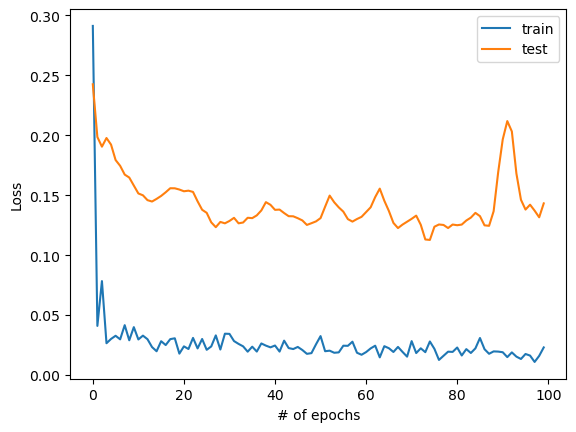

In [25]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.show()

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 400)               644800    
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 128)               51328     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6

## 7- Evaluate Model

In [26]:

# make a prediction
yhat_test = model.predict(test_X, verbose=0)
yhat_train = model.predict(train_X, verbose=0)


In [27]:
test_X.shape, train_X.shape

((15, 10, 2), (46, 10, 2))

In [28]:
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
train_X = train_X.reshape((train_X.shape[0], n_days*n_features))


In [29]:
# invert scaling for forecast
inv_yhat_test = np.concatenate((yhat_test, test_X[:, -1:]), axis=1)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:,0]


inv_yhat_train = np.concatenate((yhat_train, train_X[:, -1:]), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,0]

In [30]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y_test = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:,0]


train_y = train_y.reshape((len(train_y), 1))
inv_y_train = np.concatenate((train_y, train_X[:, -1:]), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:,0]

In [31]:
# calculate RMSE
rmse_test = np.sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
rmse_train = np.sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
print('Train RMSE is {:.3f} and Test RMSE is {:.3f}'.format(rmse_train, rmse_test))
# print('Test RMSE: %.3f' % rmse)

Train RMSE is 2.494 and Test RMSE is 11.254


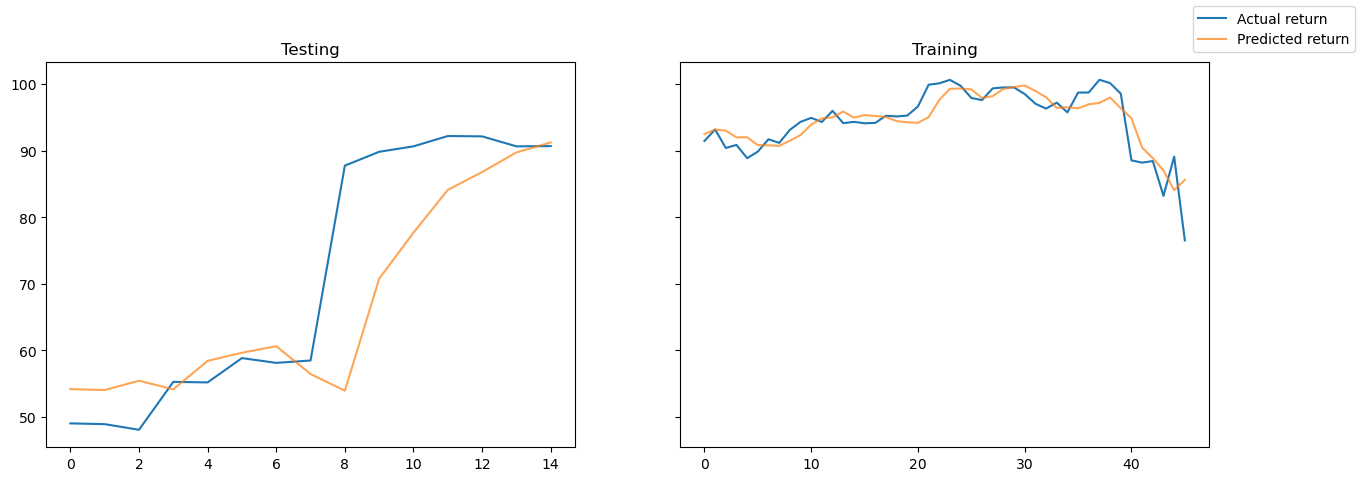

In [32]:
# plot results
fig, ax= plt.subplots(1, 2, figsize=(15,5), sharey= True)
ax[0].plot(inv_y_test)
ax[0].plot(inv_yhat_test, alpha=0.7)
ax[1].plot(inv_y_train)
ax[1].plot(inv_yhat_train, alpha=0.7)

ax[0].title.set_text('Testing')
ax[1].title.set_text('Training')

fig.legend(labels= ['Actual return', 'Predicted return'])
plt.show()

## 8- Define and fit the model for all stocks


In [33]:
def stock_prediction(tickers):
    for tic in tickers:
        df_tic= get_stock_info(tic)
        print(tic)

        #Convert dataframe to arrays and ensure all data is float
        values= df_tic.values
        values= values.astype('float32')

        # normalize features
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled = scaler.fit_transform(values)

        # frame as supervised learning
        n_days= 10
        n_features= 2
        reframed = series_to_supervised(scaled, n_days, 1)
        
        # split into train and test sets
        values = reframed.values
        n_test_hours = int(0.25 * reframed.shape[0])
        train = values[n_test_hours:, :]
        test = values[:n_test_hours, :]
        
        # split into input and outputs
        n_obs = n_days * n_features
        train_X, train_y = train[:, :n_obs], train[:, -n_features]
        test_X, test_y = test[:, :n_obs], test[:, -n_features]
#         print(train_X.shape, len(train_X), train_y.shape)

        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
        test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
#         print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

        # design network
        model = Sequential()
        model.add(LSTM(400, input_shape=(train_X.shape[1], train_X.shape[2]))) #200 neurons in the first hidden layer, input shape will be 12 time steps with 55 features
        model.add(Dropout(0.3))
        model.add(Dense(128)) #1 neuron in the output layer
        model.add(Dropout(0.3))
        model.add(Dense(64)) #1 neuron in the output layer
        model.add(Dropout(0.3))
        model.add(Dense(1, activation ='linear')) #1 neuron in the output layer
        model.compile(loss='mse', optimizer='adam', metrics= ['mse', 'mae'] )
        # fit network
        history = model.fit(train_X, train_y, epochs=100, batch_size=16, validation_data=(test_X, test_y), verbose=0, shuffle=False)

        
        # make a prediction
        yhat_test = model.predict(test_X, verbose=0)
        yhat_train = model.predict(train_X, verbose=0)


        test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
        train_X = train_X.reshape((train_X.shape[0], n_days*n_features))


        # invert scaling for forecast
        inv_yhat_test = np.concatenate((yhat_test, test_X[:, -1:]), axis=1)
        inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
        inv_yhat_test = inv_yhat_test[:,0]


        inv_yhat_train = np.concatenate((yhat_train, train_X[:, -1:]), axis=1)
        inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
        inv_yhat_train = inv_yhat_train[:,0]

        # invert scaling for actual
        test_y = test_y.reshape((len(test_y), 1))
        inv_y_test = np.concatenate((test_y, test_X[:, -1:]), axis=1)
        inv_y_test = scaler.inverse_transform(inv_y_test)
        inv_y_test = inv_y_test[:,0]


        train_y = train_y.reshape((len(train_y), 1))
        inv_y_train = np.concatenate((train_y, train_X[:, -1:]), axis=1)
        inv_y_train = scaler.inverse_transform(inv_y_train)
        inv_y_train = inv_y_train[:,0]

        # calculate RMSE
        rmse_test = np.sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
        rmse_train = np.sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
        print('Train RMSE is {:.3f} and Test RMSE is {:.3f}'.format(rmse_train, rmse_test))

        # plot results
        fig, ax= plt.subplots(1, 2, figsize=(15,5), sharey= True)
        ax[0].plot(inv_y_test)
        ax[0].plot(inv_yhat_test, alpha=0.7)
        ax[1].plot(inv_y_train)
        ax[1].plot(inv_yhat_train, alpha=0.7)

        ax[0].title.set_text('Testing')
        ax[1].title.set_text('Training')

        fig.legend(labels= ['Actual return', 'Predicted return'])
        plt.show()


AAPL
Train RMSE is 0.937 and Test RMSE is 1.849


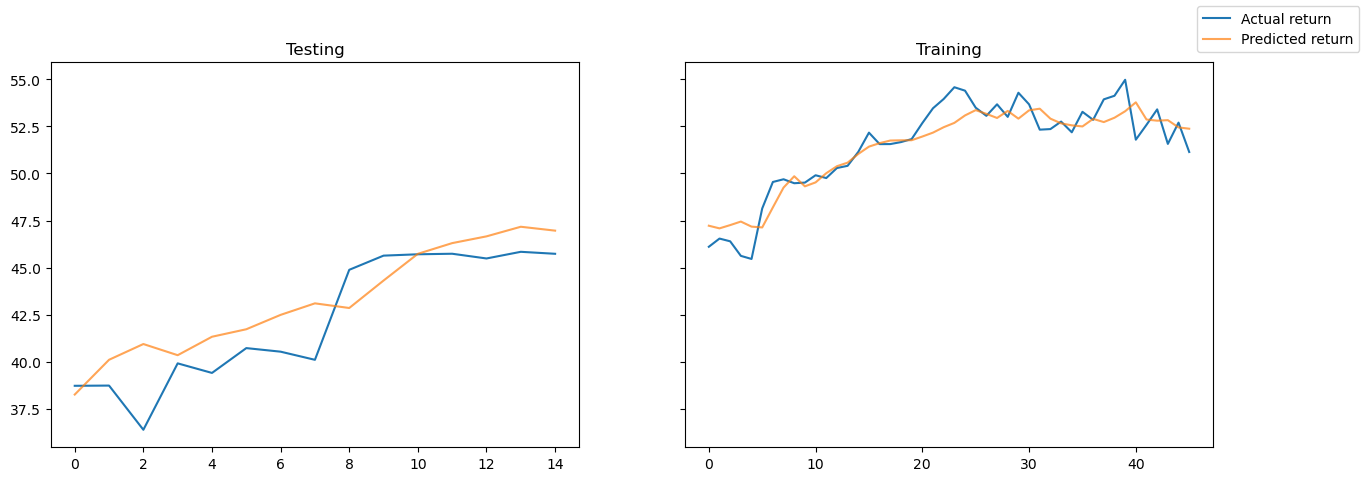

ADDYY
Train RMSE is 2.202 and Test RMSE is 3.813


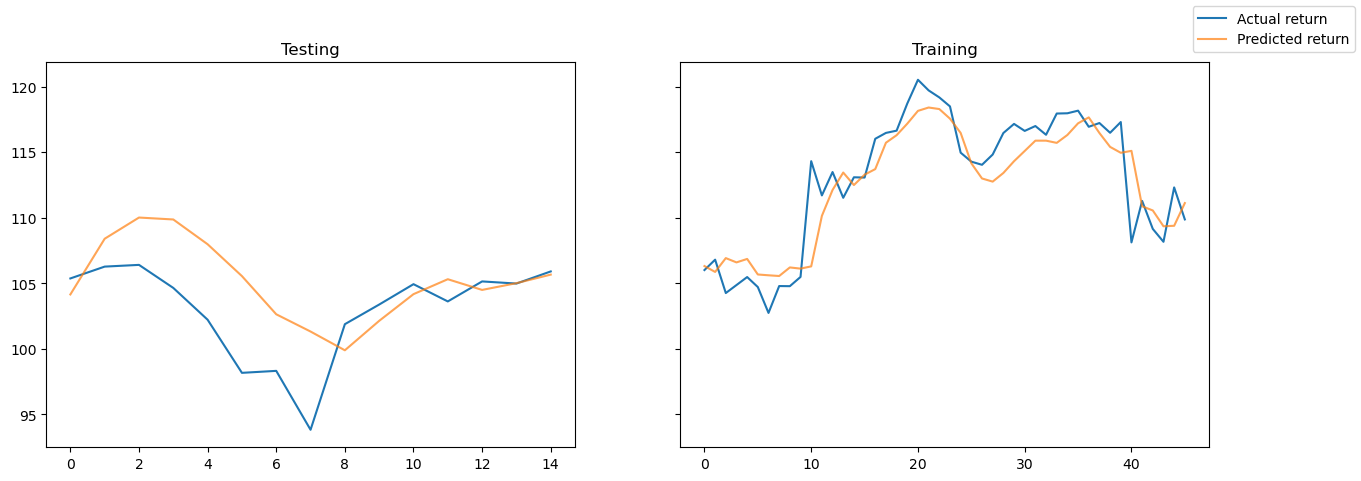

AMZN
Train RMSE is 2.992 and Test RMSE is 10.810


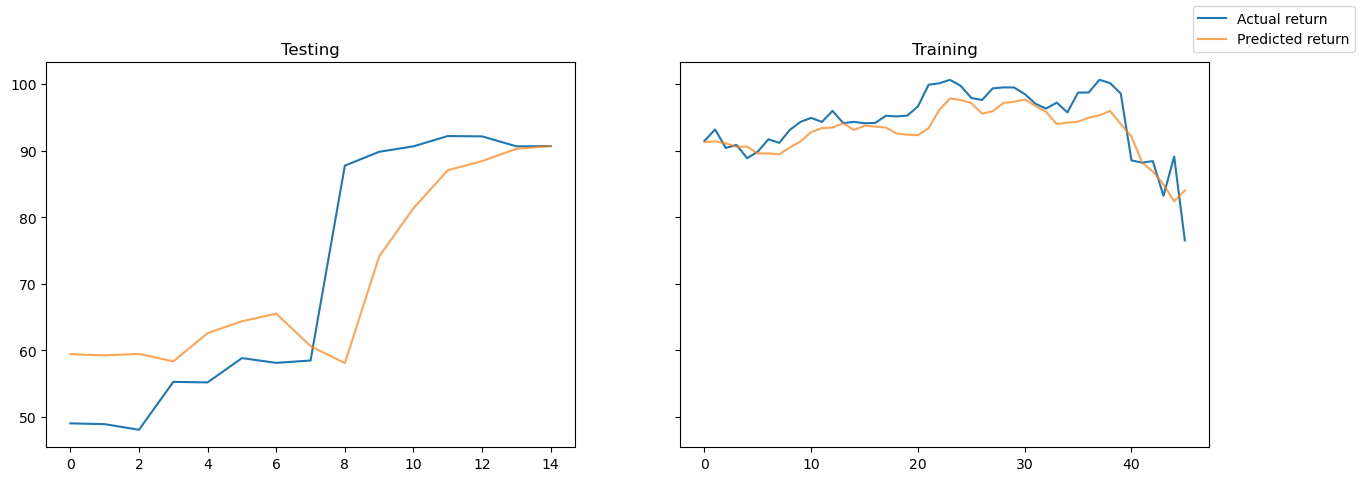

BMWYY
Train RMSE is 0.400 and Test RMSE is 1.032


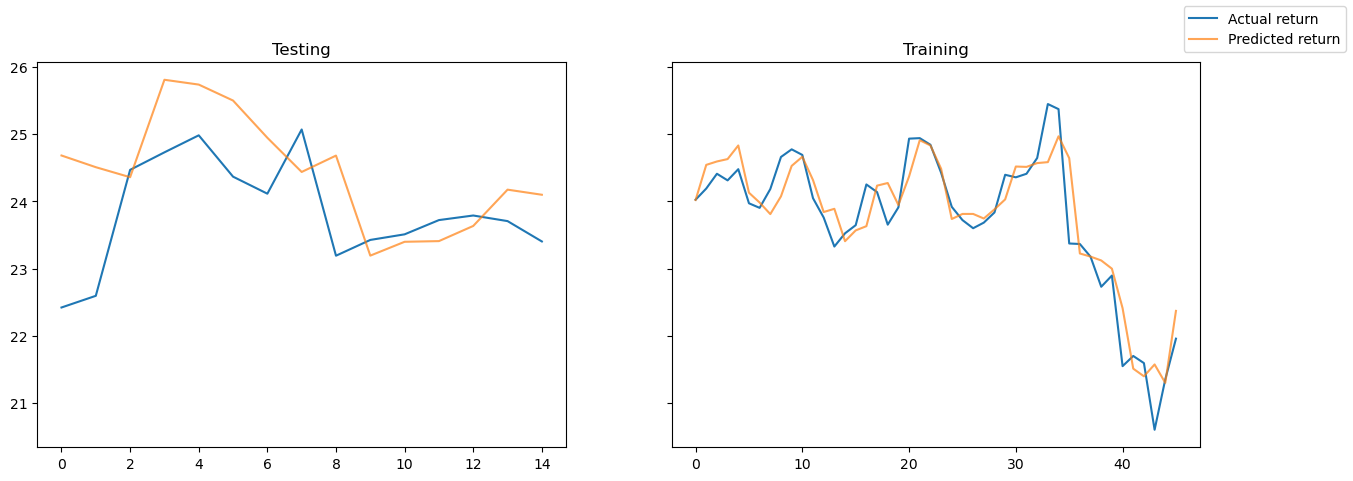

BP
Train RMSE is 0.503 and Test RMSE is 2.156


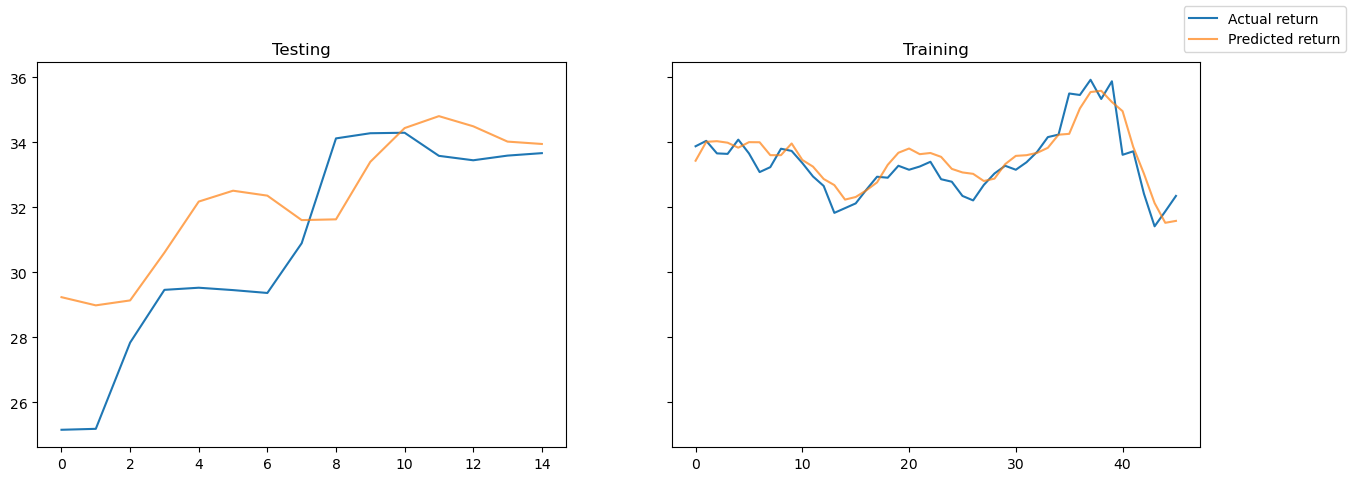

DIS
Train RMSE is 1.185 and Test RMSE is 5.578


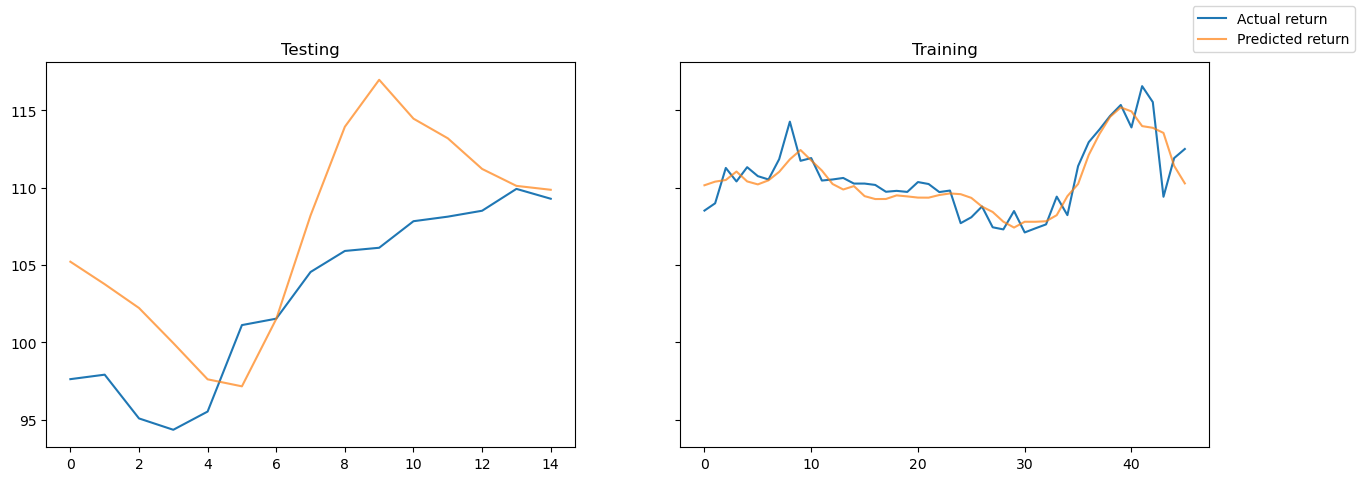

EBAY
Train RMSE is 0.493 and Test RMSE is 1.491


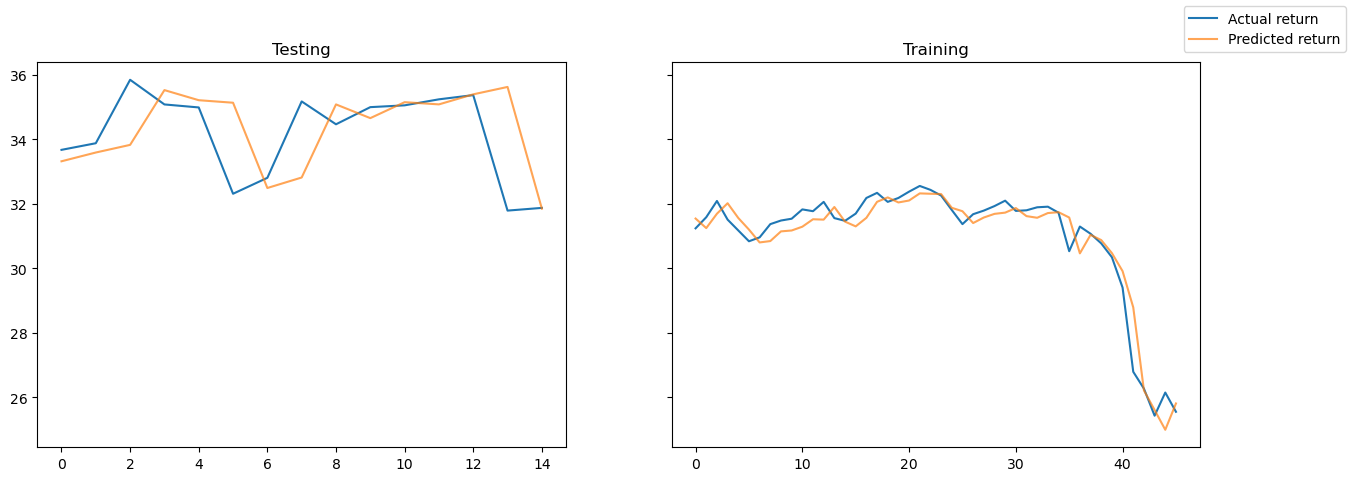

F
Train RMSE is 0.153 and Test RMSE is 0.663


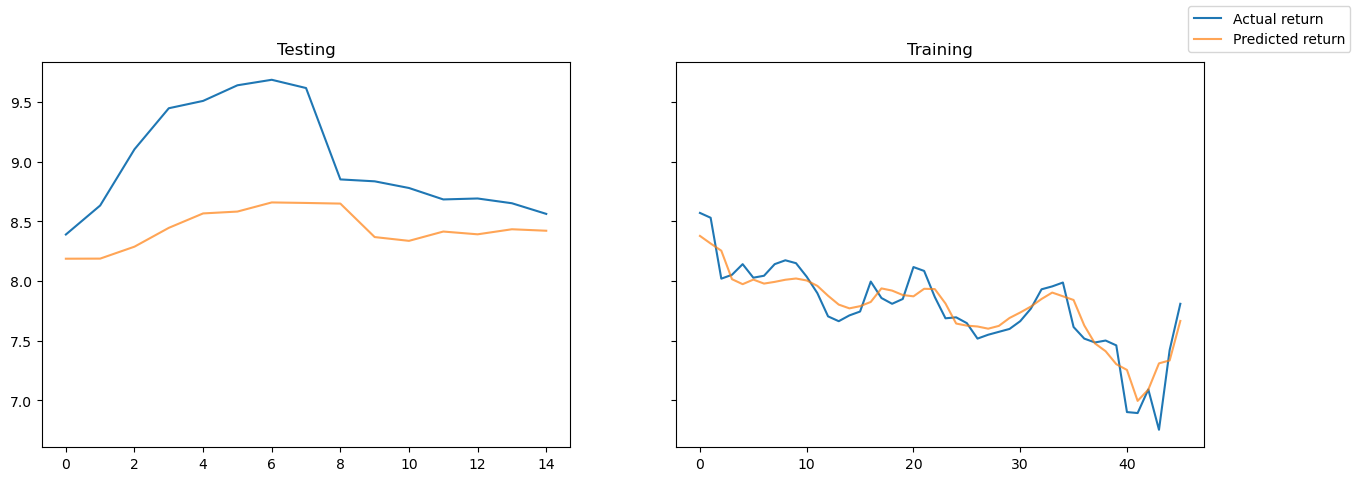

GOOGL
Train RMSE is 1.234 and Test RMSE is 2.183


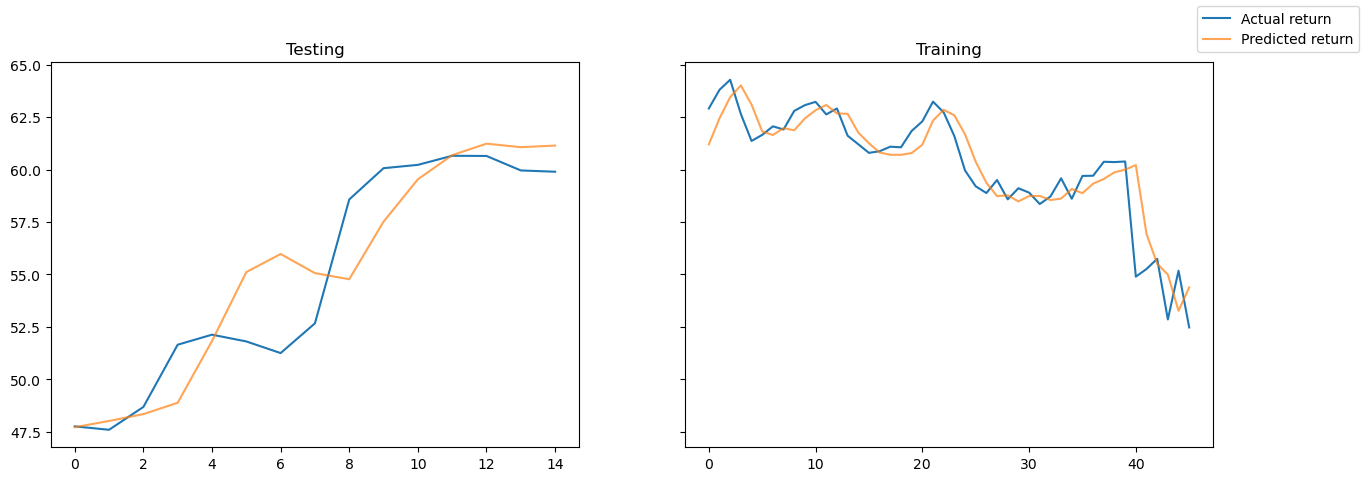

HNDAF
Train RMSE is 0.443 and Test RMSE is 1.372


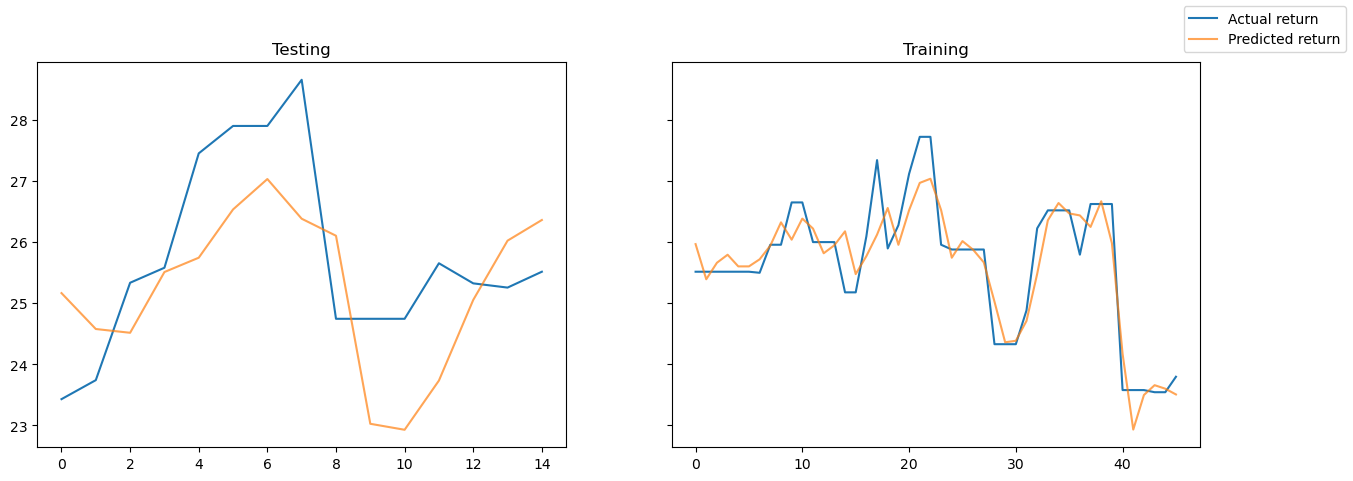

HP
Train RMSE is 0.926 and Test RMSE is 2.802


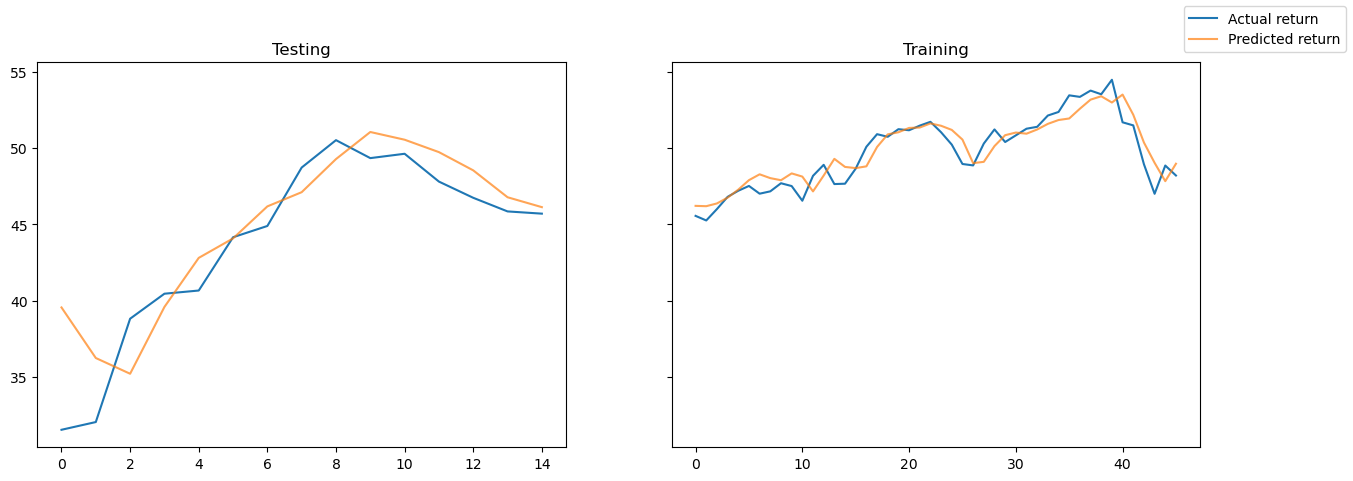

IBM
Train RMSE is 1.470 and Test RMSE is 3.607


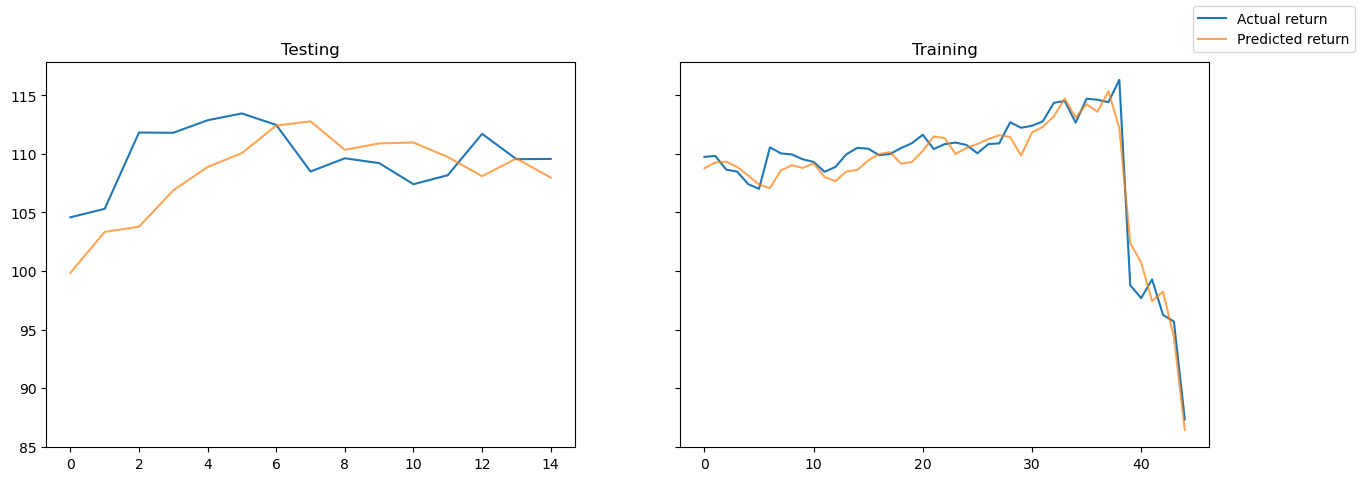

INTC
Train RMSE is 0.951 and Test RMSE is 2.696


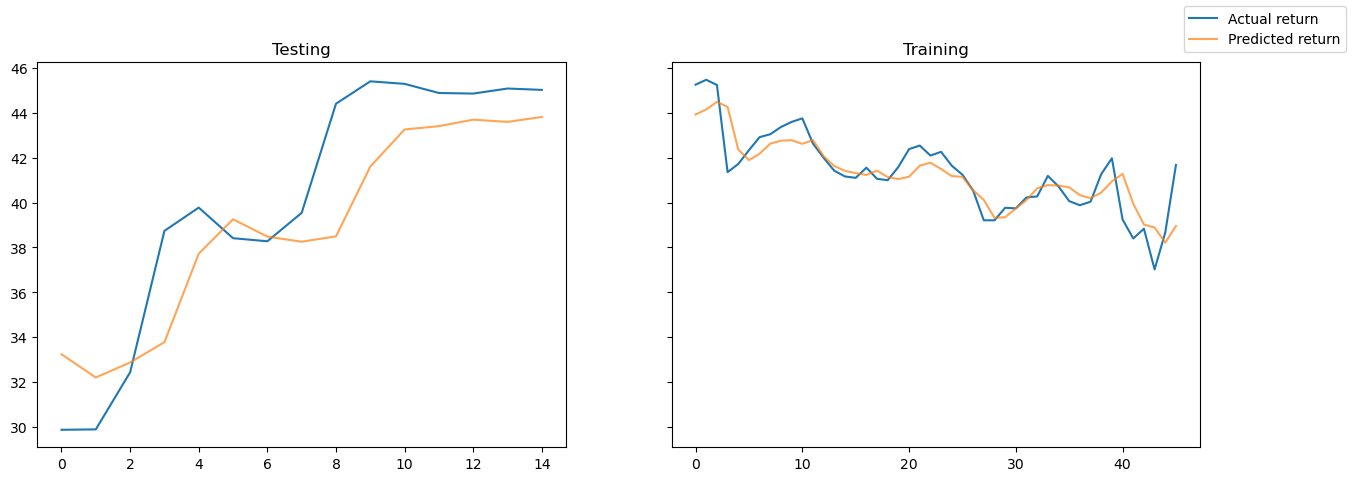

META
Train RMSE is 4.758 and Test RMSE is 14.356


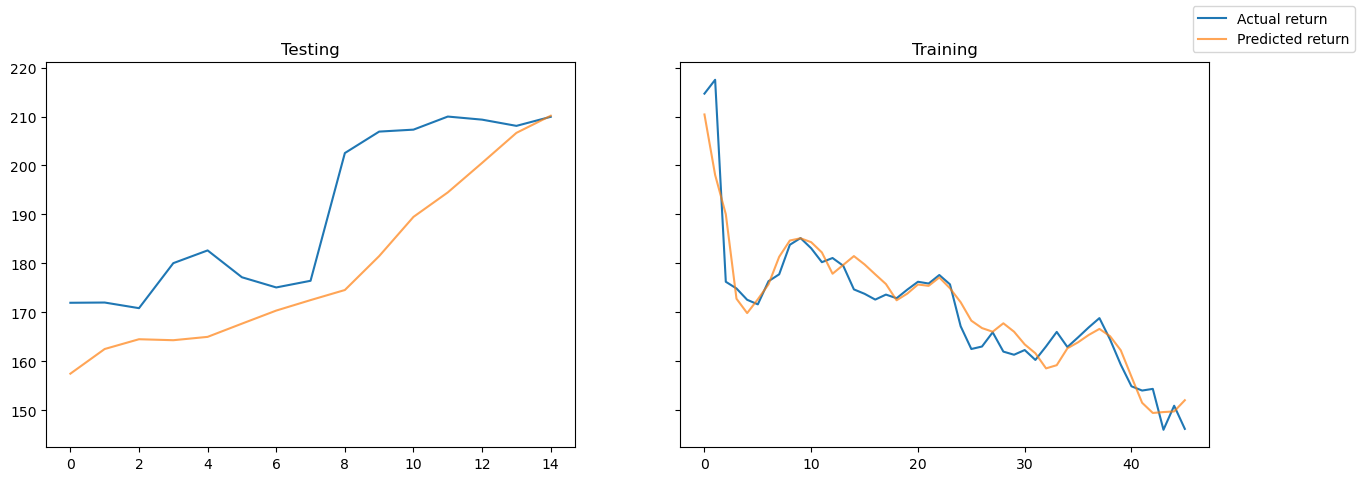

MSFT
Train RMSE is 2.083 and Test RMSE is 14.002


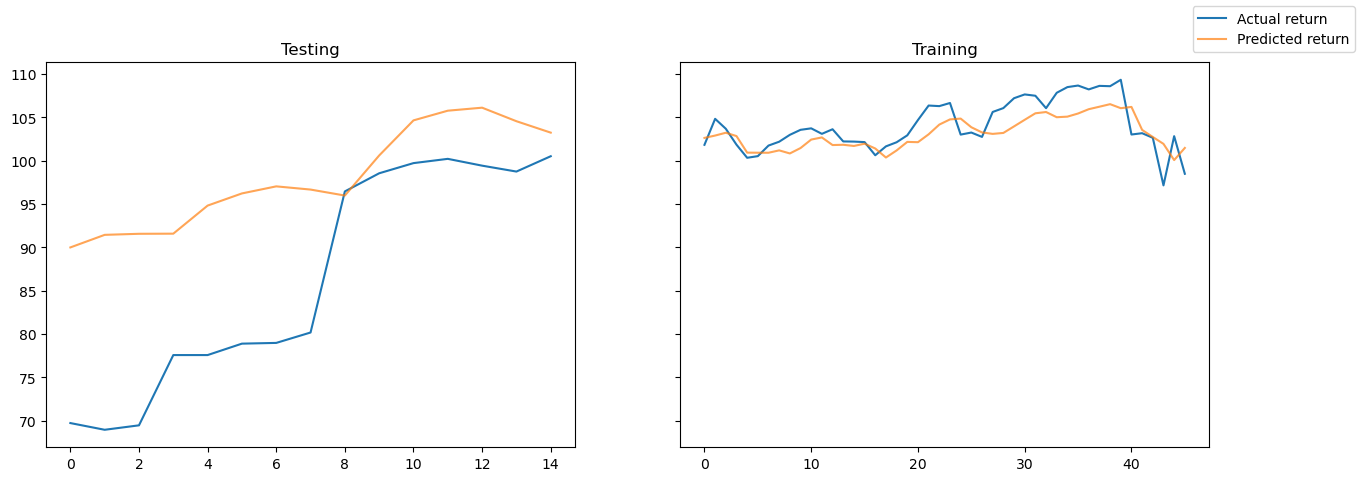

NEXT
Train RMSE is 0.235 and Test RMSE is 0.772


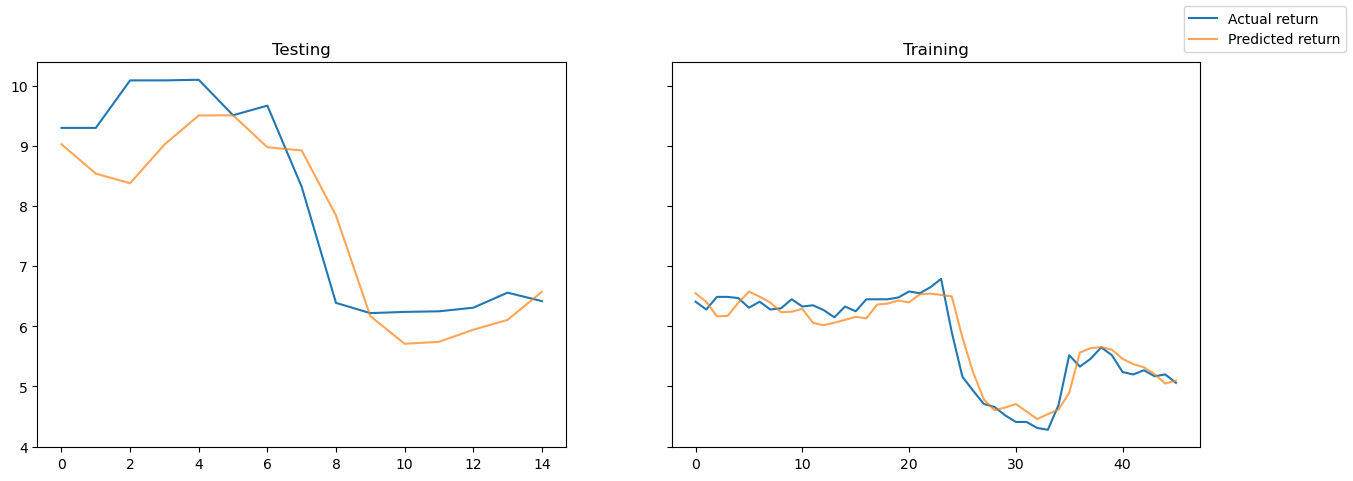

NFLX
Train RMSE is 9.458 and Test RMSE is 95.202


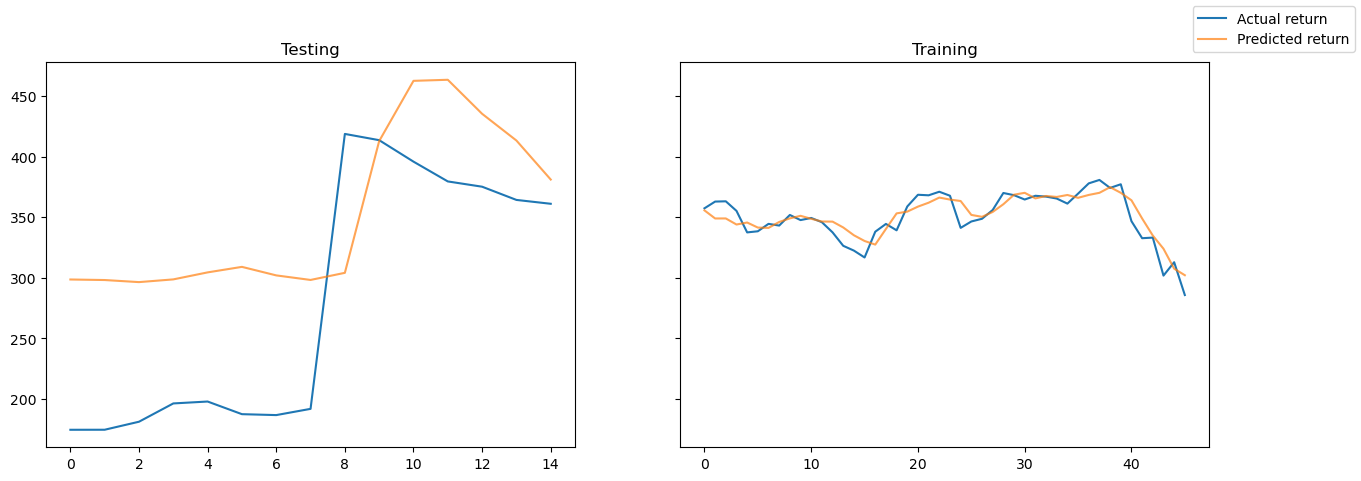

NKE
Train RMSE is 1.442 and Test RMSE is 8.017


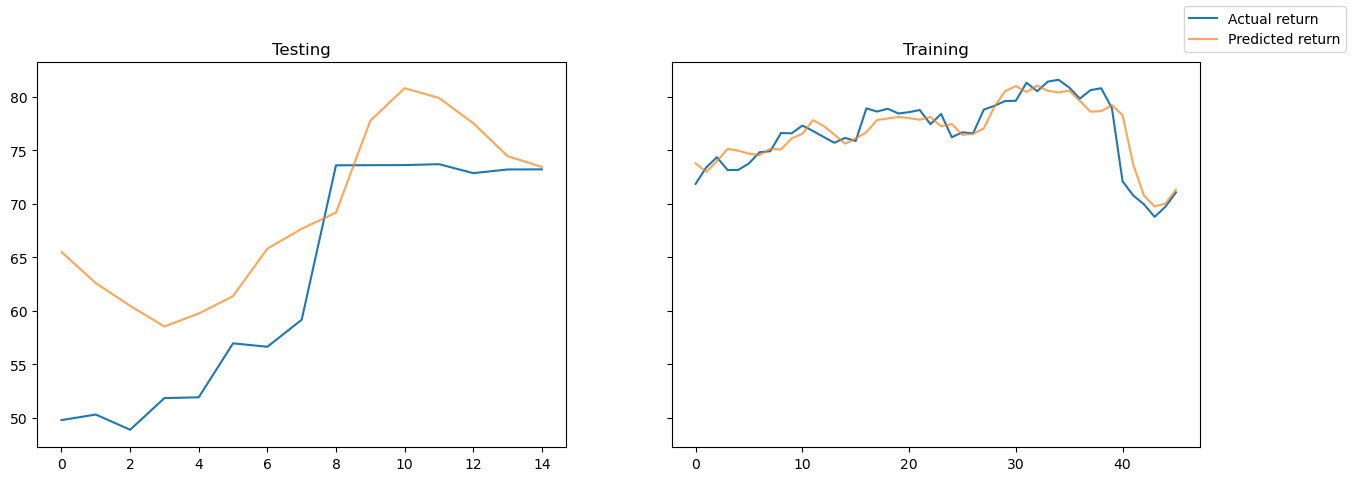

PARA
Train RMSE is 0.812 and Test RMSE is 2.652


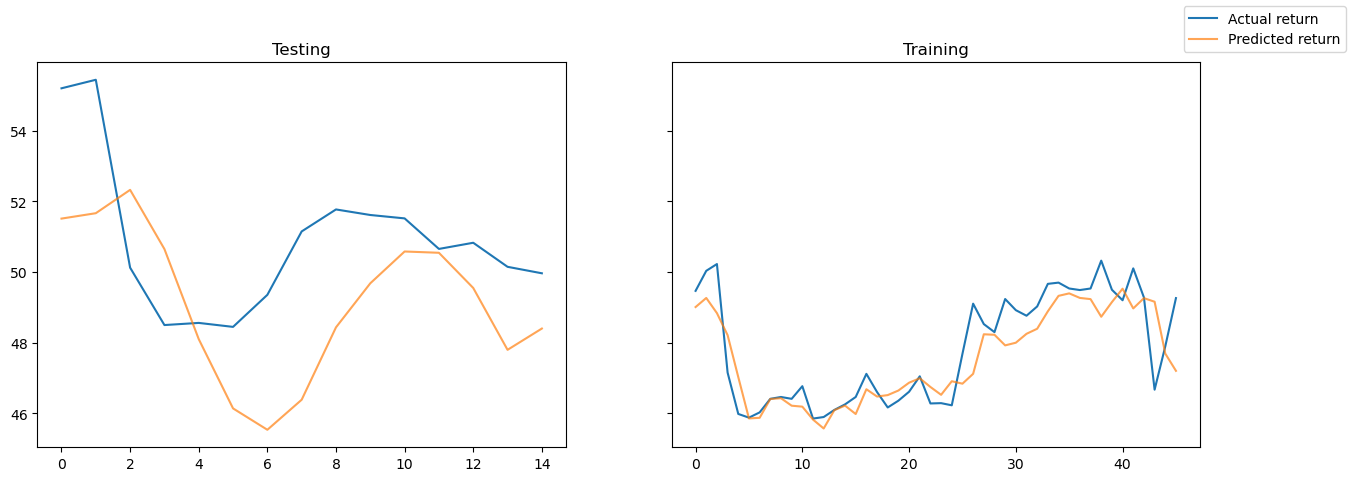

PYPL
Train RMSE is 2.486 and Test RMSE is 5.729


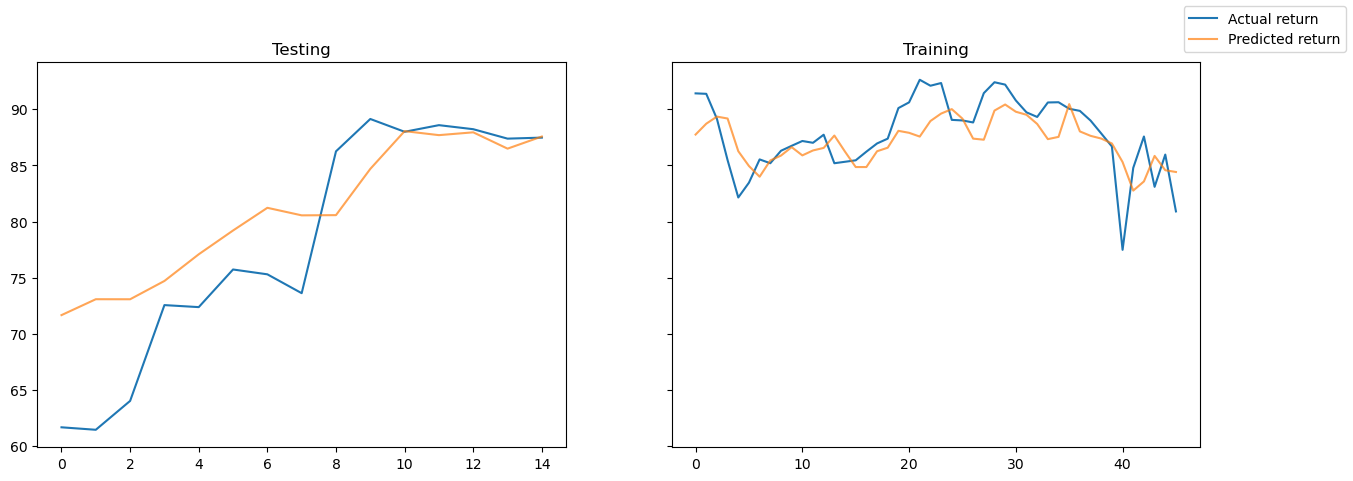

RYAAY
Train RMSE is 2.503 and Test RMSE is 6.891


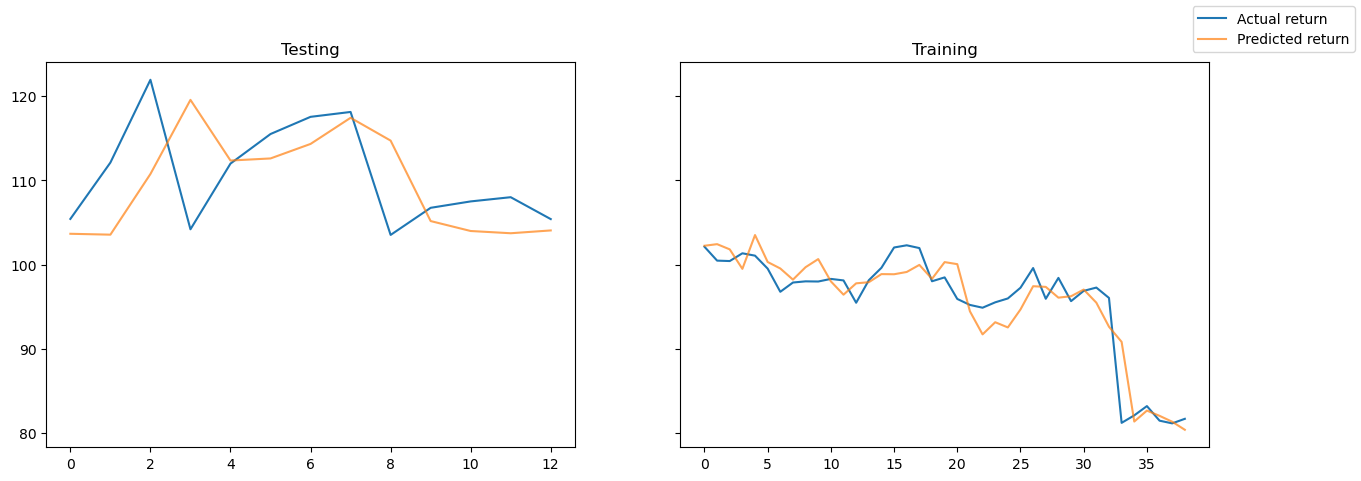

SBUX
Train RMSE is 0.553 and Test RMSE is 2.380


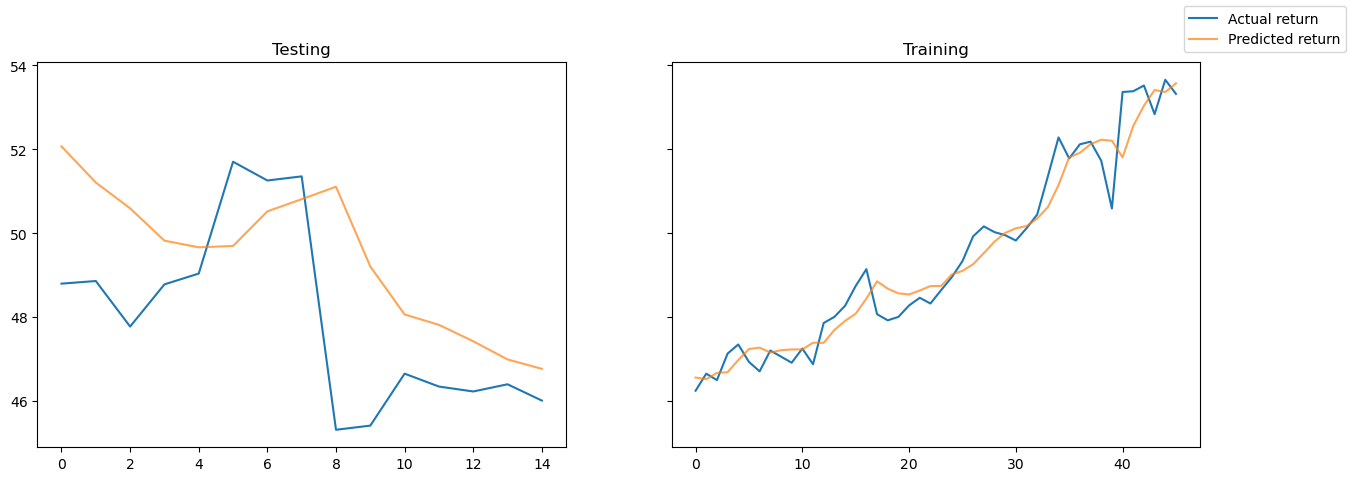

SONY
Train RMSE is 0.994 and Test RMSE is 2.838


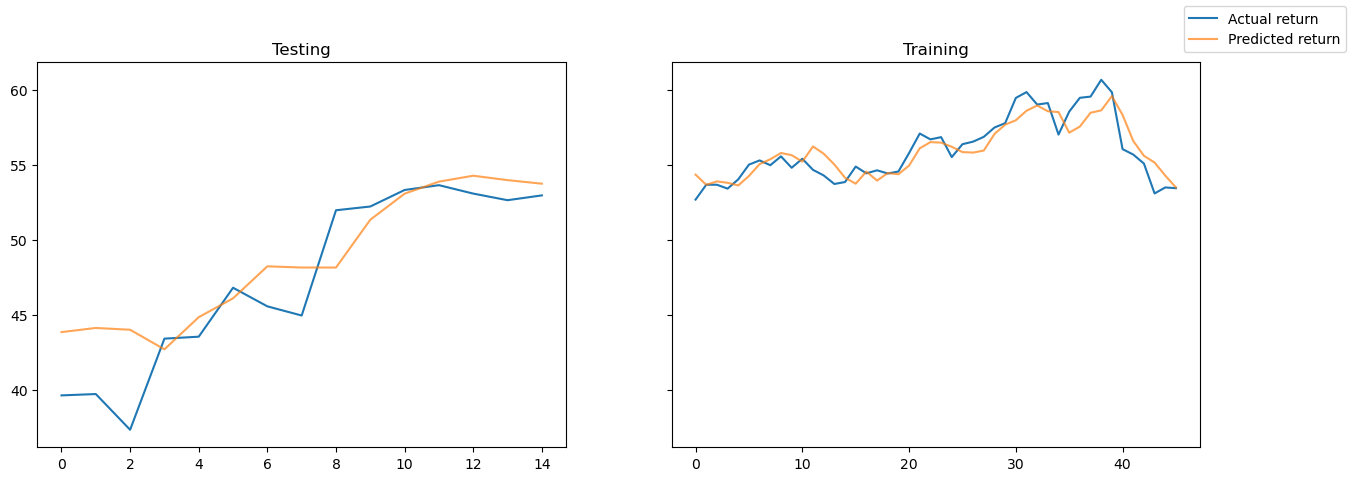

TM
Train RMSE is 1.580 and Test RMSE is 12.129


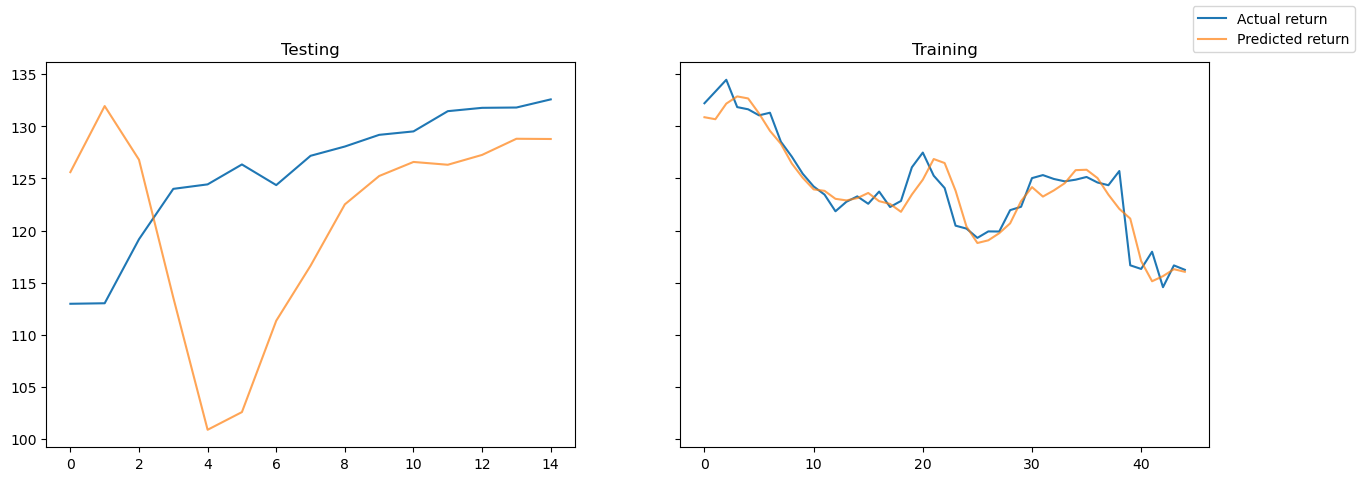

TRI
Train RMSE is 0.465 and Test RMSE is 0.989


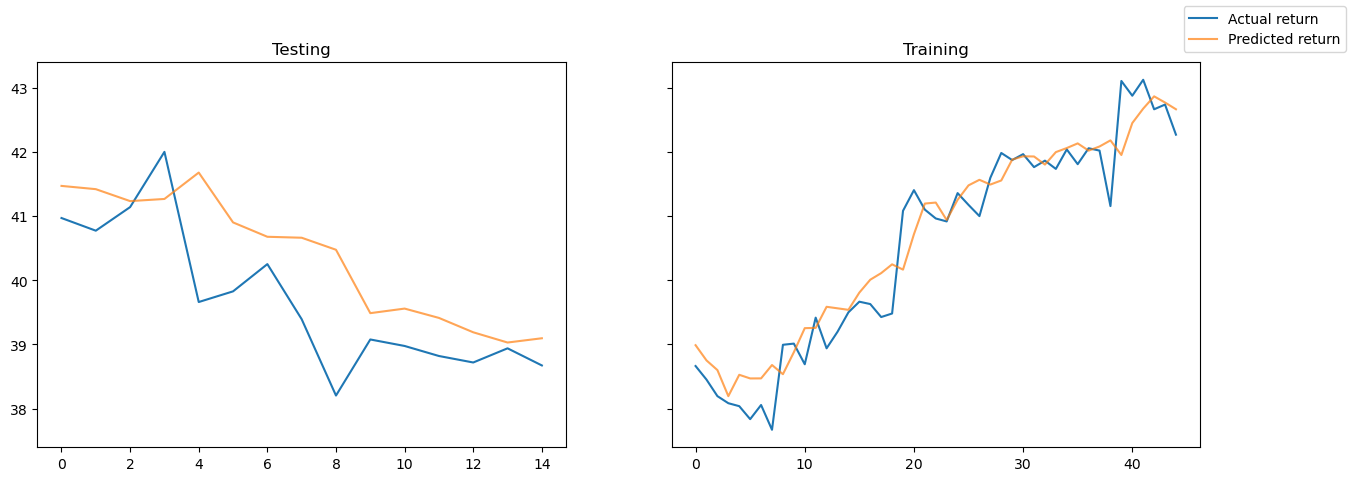

UPS
Train RMSE is 1.125 and Test RMSE is 13.205


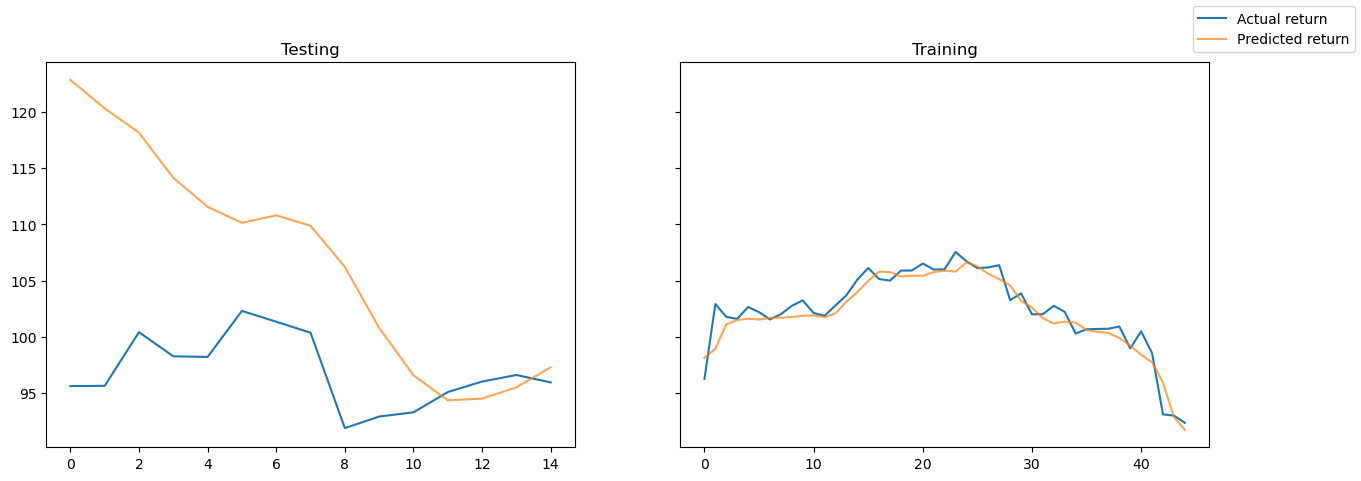

V
Train RMSE is 2.551 and Test RMSE is 6.190


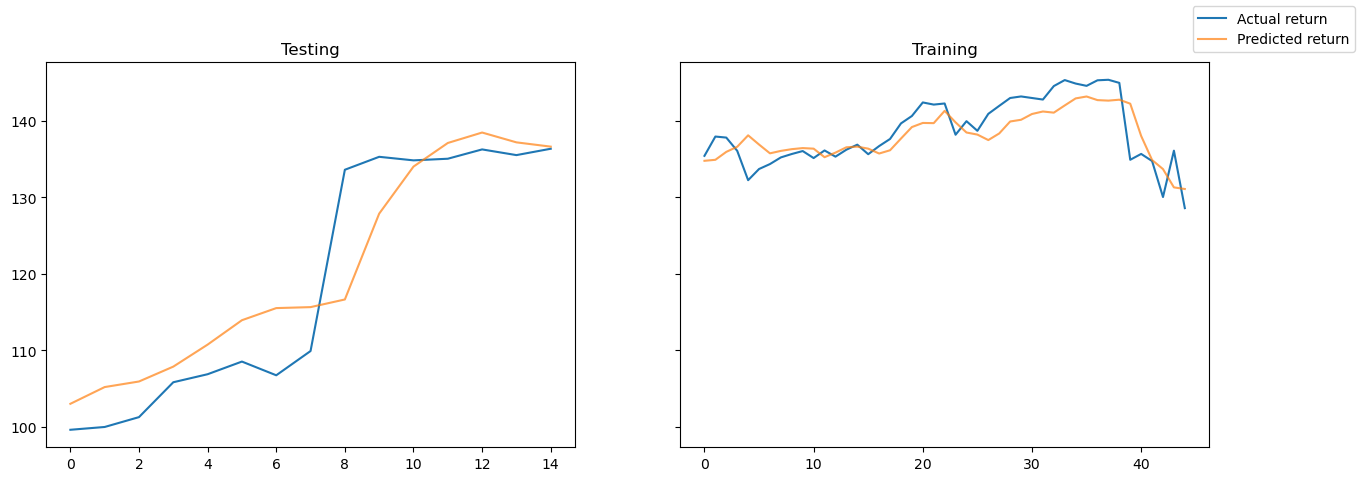

WMT
Train RMSE is 1.374 and Test RMSE is 4.778


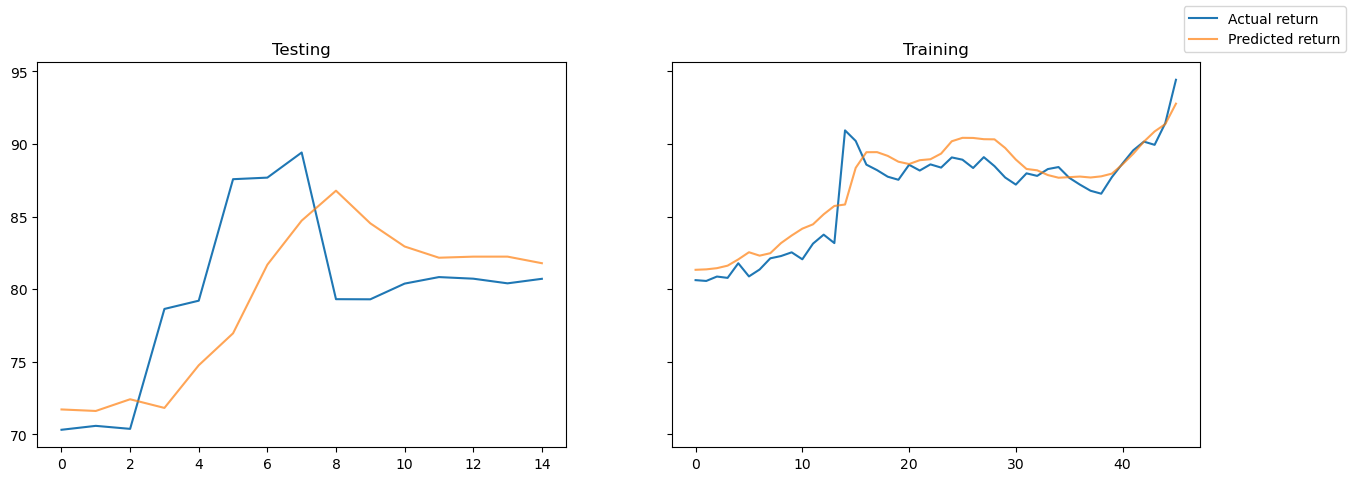

In [34]:
stock_prediction(tickers)